In [1]:
from sklearn.preprocessing import OneHotEncoder,LabelEncoder
from sklearn.pipeline import Pipeline,make_pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import ExtraTreesClassifier,RandomForestClassifier
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
from sklearn import set_config
set_config(display='diagram')
import pandas as pd
import numpy as np

In [2]:
data = pd.read_csv('data/Final_updated_data.csv',low_memory=False)

In [3]:
# data = data.drop(data.index[data['VISA_CLASS'].isin(["H-1B1 Chile","E-3 Australian","H-1B1 Singapore"])])
data.drop('VISA_CLASS',axis=1,inplace=True)
data.dropna(subset=['WAGE_UNIT_OF_PAY_1'],inplace=True)
data.reset_index(drop=True,inplace=True)

In [4]:
labelencoder = LabelEncoder()
data['WAGE_UNIT_OF_PAY_1'] = labelencoder.fit_transform(data['WAGE_UNIT_OF_PAY_1'])

In [5]:
case_status = data.CASE_STATUS
wage_unit_pay = data.WAGE_UNIT_OF_PAY_1

In [6]:
imputer = SimpleImputer(missing_values=np.nan)
data = pd.DataFrame( imputer.fit_transform(data.drop(['WAGE_UNIT_OF_PAY_1','CASE_STATUS'],axis=1)),columns=data.columns.difference(['WAGE_UNIT_OF_PAY_1','CASE_STATUS']))

In [7]:
data['CASE_STATUS'] = case_status
data['WAGE_UNIT_OF_PAY_1'] = wage_unit_pay

In [8]:
data = data[['NEW_EMPLOYMENT','NEW_CONCURRENT_EMPLOYMENT','CHANGE_PREVIOUS_EMPLOYMENT', 'CONTINUED_EMPLOYMENT',               
        'AMENDED_PETITION','CHANGE_EMPLOYER', 'TOTAL_WORKER_POSITIONS','WAGE_UNIT_OF_PAY_1',
        'FULL_TIME_POSITION','SECONDARY_ENTITY_1','AGENT_REPRESENTING_EMPLOYER',
       'H-1B_DEPENDENT', 'WILLFUL_VIOLATOR', 'WAGE_RATE_OF_PAY_FROM_1',
       'WAGE_RATE_OF_PAY_TO_1', 'PREVAILING_WAGE_1','CASE_STATUS']]

In [9]:
scaler= MinMaxScaler(feature_range=(0,1))
data = pd.DataFrame(scaler.fit_transform(data),columns=data.columns)

In [10]:
X = data.drop('CASE_STATUS',axis=1)
y = data.CASE_STATUS
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.4, random_state=42)

# Feature Selection

In [11]:
ETclassifier = ExtraTreesClassifier(n_estimators=100,criterion='entropy',max_features=2)
ETclassifier.fit(X,y)

feature_importance = ETclassifier.feature_importances_

feature_importance_normalized = np.std([tree.feature_importances_ for tree in 
                                        ETclassifier.estimators_],
                                        axis = 0)

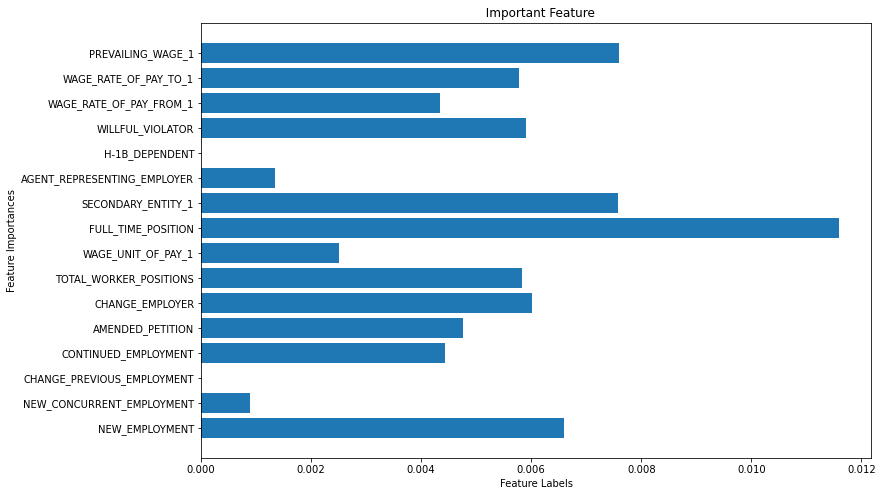

In [12]:
plt.figure(figsize=(12, 8))
plt.barh(X.columns, feature_importance_normalized)
plt.xlabel('Feature Labels')
plt.ylabel('Feature Importances')
plt.title('  Important Feature')
plt.show()

# Logistic Regression

### With Pipelines

In [13]:
trnf1 = ColumnTransformer(
                [
                    ('missing-nan',SimpleImputer(missing_values=np.nan,strategy='mean'),slice(15)),
                ],
            remainder='passthrough')

In [131]:
trnf2 = ColumnTransformer(
                [
                    ('OneHotEncoder',LabelEncoder(handle_unknown='ignore',sparse=False),[16]),
                ],
            remainder='passthrough')

In [171]:
trnf3 = ColumnTransformer(
                [
                    ('MinMaxScaler',MinMaxScaler(feature_range=(0, 1)),slice(16))
                    
                ],
                remainder='passthrough'
                )

In [172]:
trnf4 = LogisticRegression()

In [173]:
pipe = Pipeline([
    ('trnf1',trnf1),
    ('trnf2',trnf2),
    ('trnf3',trnf3),
    ('trnf4',trnf4)
])

In [174]:
pipe

Pipeline(steps=[('trnf1',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('missing-nan',
                                                  SimpleImputer(),
                                                  slice(None, 15, None))])),
                ('trnf2',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('OneHotEncoder',
                                                  LabelEncoder(), [16])])),
                ('trnf3',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('MinMaxScaler',
                                                  MinMaxScaler(),
                                                  slice(None, 16, None))])),
                ('trnf4', LogisticRegression())])

In [ ]:
pipe.fit(X_train,y_train)

In [ ]:
y_pred = pipe.predict(X_test)

In [18]:
accuracy_score(y_test,y_pred)

0.9872096442222875

## Without Pipelines

In [14]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn import metrics

def roc_curve_graph(X_test,y_test,model,model_name):
    ns_probs = [0 for _ in range(len(y_test))]
    lr_probs = model.predict_proba(X_test)
    lr_probs = lr_probs[:, 1]
    # calculate scores
    ns_auc = metrics.roc_auc_score(y_test, ns_probs)
    lr_auc = metrics.roc_auc_score(y_test, lr_probs)
    # summarize scores
    print('No Skill: ROC AUC = %.3f' % (ns_auc))
    print(f'{model_name} : ROC AUC = %.3f' % (lr_auc))
    # calculate roc curves
    ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
    lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
    # plot the roc curve for the model
    plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
    plt.plot(lr_fpr, lr_tpr, marker='.', label=model_name)
    # axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    # show the legend
    plt.legend()
    # show the plot
    plt.show()

    
def metrics_cal(x_test,y_test,prediction,model):    
    print("Model Accuracy:",metrics.accuracy_score(y_test, prediction))
    probs = model.predict_proba(x_test)
    roc_auc = metrics.roc_auc_score(y_test, probs[:,1]) 
    print("ROC:",roc_auc)
    print("Confusion Matrix:",metrics.confusion_matrix(y_test, prediction)) 
    print("Classification Report:", metrics.classification_report(y_test, prediction))  
    print("precision:",metrics.precision_score(y_test, prediction, pos_label=1))  
    print("Recall:",metrics.recall_score(y_test, prediction, pos_label=1))  
    print("F1 Score:",metrics.f1_score(y_test, prediction, pos_label=1))
    
def train_test_acc(model,x_train,y_train,x_test,y_test):
    print('Accuracy on training set: {:.2f}'.format(model.score(x_train, y_train)))
    print('Accuracy on test set: {:.2f}'.format(model.score(x_test, y_test)))

### Model 1

In [15]:
lr2 = LogisticRegression(max_iter=5000,multi_class='multinomial').fit(X_train,y_train)

Accuracy on training set: 0.99
Accuracy on test set: 0.99
Model Accuracy: 0.9863518391456102
ROC: 0.665961081420814
Confusion Matrix: [[     2   1829]
 [     1 132252]]
Classification Report:               precision    recall  f1-score   support

         0.0       0.67      0.00      0.00      1831
         1.0       0.99      1.00      0.99    132253

    accuracy                           0.99    134084
   macro avg       0.83      0.50      0.50    134084
weighted avg       0.98      0.99      0.98    134084

precision: 0.9863589919526257
Recall: 0.9999924387348491
F1 Score: 0.9931289283381018
No Skill: ROC AUC = 0.500
Logistic Reg. : ROC AUC = 0.666


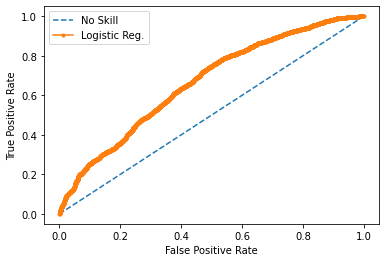

In [16]:
y_pred = lr2.predict(X_test)
train_test_acc(lr2,X_train,y_train,X_test,y_test)
metrics_cal(X_test,y_test,y_pred,lr2)
roc_curve_graph(X_test,y_test,lr2,'Logistic Reg.')

### Model 2

In [17]:
lr3 = LogisticRegression(max_iter=5000, random_state=42)
scores = cross_val_score(lr3, X, y, cv=5)
scores

array([0.9860386 , 0.98606843, 0.98602369, 0.98602369, 0.98600877])

In [18]:
print("%0.4f accuracy with a standard deviation of %0.4f" % (scores.mean(), scores.std()))

0.9860 accuracy with a standard deviation of 0.0000


So, model 2 is a little bit better than model 1 and model 2  with accuracy of 98.64%

# Random Forest

## Model 1

In [19]:
rfc = RandomForestClassifier(max_depth=2, random_state=0)
rfc.fit(X_train, y_train)

RandomForestClassifier(max_depth=2, random_state=0)

Accuracy on training set: 0.99
Accuracy on test set: 0.99
Model Accuracy: 0.9863443811342144
ROC: 0.675459093817762
Confusion Matrix: [[     0   1831]
 [     0 132253]]


/home/bing0/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/bing0/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/bing0/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report:               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      1831
         1.0       0.99      1.00      0.99    132253

    accuracy                           0.99    134084
   macro avg       0.49      0.50      0.50    134084
weighted avg       0.97      0.99      0.98    134084

precision: 0.9863443811342144
Recall: 1.0
F1 Score: 0.9931252510916622
No Skill: ROC AUC = 0.500
Random Forest : ROC AUC = 0.675


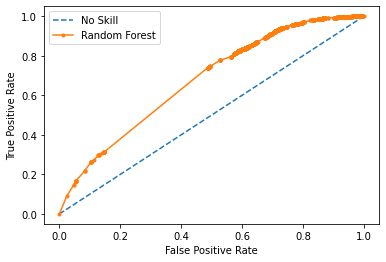

In [20]:
y_pred = rfc.predict(X_test)
train_test_acc(rfc,X_train,y_train,X_test,y_test)
metrics_cal(X_test,y_test,y_pred,rfc)
roc_curve_graph(X_test,y_test,rfc,'Random Forest')

## Model 2

In [21]:
rfc2 = RandomForestClassifier(max_depth=5000,max_leaf_nodes=5,max_samples=5, random_state=0)
cores = cross_val_score(rfc2, X, y, cv=5)
scores

array([0.9860386 , 0.98606843, 0.98602369, 0.98602369, 0.98600877])

In [22]:
print("%0.4f accuracy with a standard deviation of %0.4f" % (scores.mean(), scores.std()))

0.9860 accuracy with a standard deviation of 0.0000


In [23]:
#Model Tuning yet to do

In [24]:
import pickle 

In [25]:
pickle.dump(lr2,open('Logistic_reg.pkl','wb'))

In [26]:
pickle.dump(rfc2,open('Random_forrest.pkl','wb'))

In [27]:
data.loc[123]

NEW_EMPLOYMENT                 0.100000
NEW_CONCURRENT_EMPLOYMENT      0.000000
CHANGE_PREVIOUS_EMPLOYMENT     0.000000
CONTINUED_EMPLOYMENT           0.000000
AMENDED_PETITION               0.000000
CHANGE_EMPLOYER                1.000000
TOTAL_WORKER_POSITIONS         0.000000
WAGE_UNIT_OF_PAY_1             1.000000
FULL_TIME_POSITION             0.000000
SECONDARY_ENTITY_1             0.000000
AGENT_REPRESENTING_EMPLOYER    1.000000
H-1B_DEPENDENT                 0.000000
WILLFUL_VIOLATOR               0.154975
WAGE_RATE_OF_PAY_FROM_1        0.082884
WAGE_RATE_OF_PAY_TO_1          0.051667
PREVAILING_WAGE_1              0.000000
CASE_STATUS                    1.000000
Name: 123, dtype: float64

In [30]:
lr2.predict(pd.DataFrame(data.drop('CASE_STATUS',axis=1).loc[123].values.reshape(1,16),
                         columns=data.drop('CASE_STATUS',axis=1).loc[123].index))

array([1.])